In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

import torch
import os
import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

In [4]:
model_name="meta-llama/Llama-2-7b-chat-hf"
# model_name="lmsys/vicuna-7b-v1.5-16k"
# model_name="mistralai/Mistral-7B-Instruct-v0.2"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, low_cpu_mem_usage=True,attn_implementation="eager", device_map="auto")

tokenizer=AutoTokenizer.from_pretrained(model_name, use_fast=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
FONTSIZE = 16

font_config = {'font.size': FONTSIZE, 'font.family': 'DejaVu Math TeX Gyre'}
plt.rcParams.update(font_config)
plt.rcParams["figure.figsize"] = (4, 4.5)

model_name = 'Llama-2-7b-hf' # replace with your model name
# model_name = 'gemma-7b-hf'
# model_name="Mistral-7B-Instruct-v0.2"
# model_name="Meta-Llama-3-8B"
# generate kv cache and attention

sample="The following are multiple choice questions (with answers) about machine learning.\n\n A 6-sided die is rolled 15 times and the results are: side 1 comes up 0 times;"
valenc = tokenizer(sample, return_tensors='pt', add_special_tokens=False).input_ids.to("cuda:0")
with torch.no_grad():
    outputs = model(valenc, use_cache=True, output_attentions=True)
past_key_values = outputs.past_key_values
attentions = outputs.attentions
# torch.save(past_key_values, f'./{model_name}_kvcache.pt')
# torch.save(attentions, f'./{model_name}_attention.pt')

# model = 'Llama-2-7b-hf' # replace with your model name
# kv_filename = f'./{model_name}_kvcache.pt'
# attn_filename = f'./{model_name}_attention.pt'
# kvcache = torch.load(kv_filename, map_location='cpu')
# attentions = torch.load(attn_filename, map_location='cpu')

kvcache = past_key_values
# attentions =

In [12]:
layer_id=20
head_id=21
k, v = kvcache[layer_id][0].squeeze(0), kvcache[layer_id][1].squeeze(0)

k = k.transpose(0, 1).abs().detach()
v = v.transpose(0, 1).abs().detach()
k, v = k[:, head_id, :], v[:, head_id, :]
l1_norms=v.norm(p=1,dim=-1)
# print(l1_norms)
atten=attentions[layer_id][0,head_id].cpu()

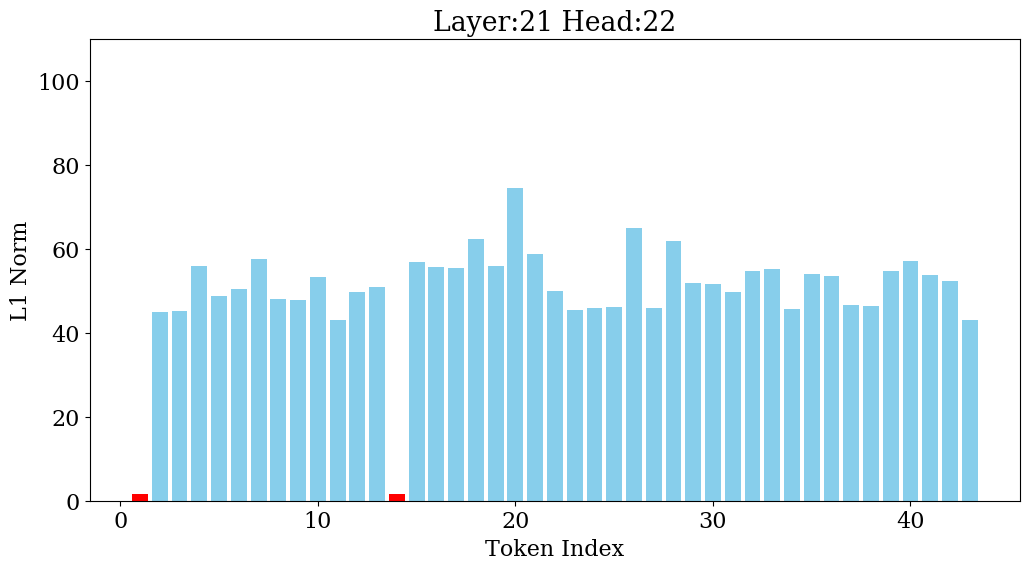

In [17]:
tokens = np.arange(1, len(l1_norms) + 1)

# Plotting the L1 norms
l1_norms=l1_norms.cpu()
plt.figure(figsize=(12, 6))
plt.bar(tokens, l1_norms.cpu(), color='skyblue')
plt.xlabel('Token Index')
plt.ylabel('L1 Norm')
plt.title(f'Layer:{layer_id+1} Head:{head_id+1}')
plt.ylim(0, 110)

highlight_tokens = [1, 14]
highlight_values = [l1_norms[i-1] for i in highlight_tokens]
plt.bar(highlight_tokens, highlight_values, color='red')
# plt.savefig(f"l1norm{model_name}_layer{layer_id+1}_head{head_id+1}.pdf", bbox_inches="tight", dpi=200)
plt.show()
# plt.savefig(f"{model_name}_layer{layer_id+1}_head{head_id+1}.pdf", bbox_inches="tight", dpi=200)

In [ ]:
def plot_attn_sub(ax, corr, model_name, layer_id):
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask, k=1)] = True

    # Apply log scale
    log_corr = np.log10(corr + 1e-6)  # Adding a small constant to avoid log(0)

    sns.heatmap(log_corr, mask=mask, square=True, ax=ax, cmap="YlGnBu", cbar_kws={"shrink": 1.0, "pad": 0.01, "aspect": 50})

    ax.set_facecolor("whitesmoke")
    cax = ax.figure.axes[-1]
    cax.tick_params(labelsize=18)

    ax.tick_params(axis='x', which='major')
    ax.set(xticklabels=[])
    ax.set(yticklabels=[])
    ax.tick_params(left=False, bottom=False)
    ax.set_title(f"Layer:{layer_id+1} Head:{head_id+1}", fontsize=24, fontweight="bold")

def plot_attn(attn_logits, model_name, layer_id):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 4.75))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.15)

    corr = attn_logits.numpy()
    corr = corr.astype("float64")

    plot_attn_sub(axs, corr, model_name, layer_id)
    # plt.savefig(f"attention{model_name}_layer{layer_id+1}_head{head_id+1}.pdf", bbox_inches="tight", dpi=200)
    plt.show()


plot_attn(atten,model_name,layer_id)